In [1]:
import pandas as pd
from file_paths_and_consts import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('classic')
import seaborn as sns
import geopandas as gpd
import random
sns.set()
import os
SEED_VALUE = 590
random.seed(SEED_VALUE)

OUTPUT_DIR

'/project/biocomplexity/UKR_forecast/migration_data/AAMAS_output_data/'

In [2]:
import multiprocessing as mp
import numpy as np
def calc_attitude_parallel(num):
    return num**2,num**3

def multiproc_attitude(all_nums):
    cpus = 4#mp.cpu_count()
    #st_time = time.time()
    hh_splits = np.array_split(all_nums, cpus) #--this a list with multiple dataframe.. each dataframe is used by one core
    #print(hh_splits)
    pool_args = [h_chunk for h_idx,h_chunk in enumerate(hh_splits)]
    #print('total time taken to split',time.time()-st_time)
    pool = mp.Pool(processes = cpus)
    results = pool.map(calc_attitude_parallel, pool_args)
    pool.close()
    pool.join()
    return results

ss = []

for i in range(0,100):
    ss.append(i)
    
results = multiproc_attitude(ss)
print(type(results[0][1]))

<class 'numpy.ndarray'>


In [3]:
pd.__version__

'1.1.0'

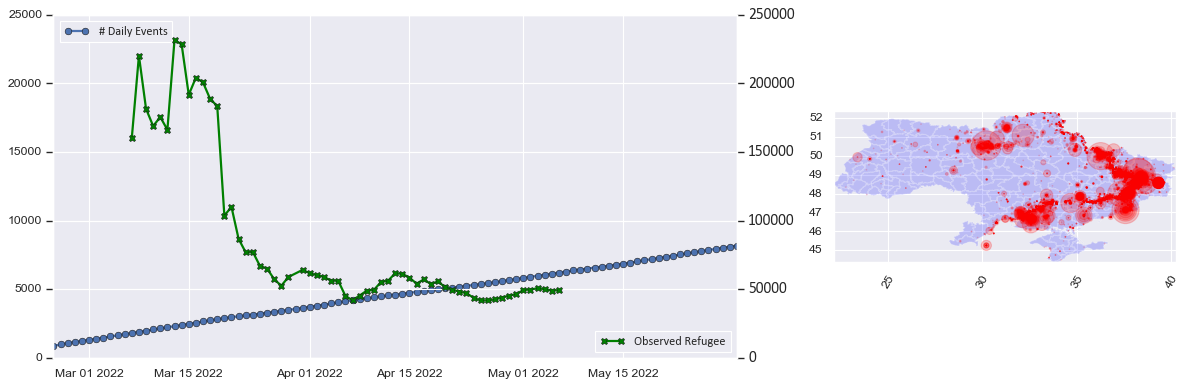

In [4]:
ROLLING = 7
conflict_data_file = UNCLEANED_DATA_DIR+'ukraine_conflict_data_feb_oct.csv'
refugee_data_file = GROUND_TRUTH_DIR+'ukraine_refugee_data_2.csv'
geo_shp_file = UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'

conflict_data = pd.read_csv(conflict_data_file)
conflict_data['time'] = pd.to_datetime(conflict_data['event_date'])
conflict_data = conflict_data.sort_values(by='time')
conflict_count = conflict_data[['time','fatalities']].groupby('time')['fatalities'].count().reset_index()
conflict_count['fatalities'] = conflict_count['fatalities'].cumsum()
conflict_count['fatalities'] = conflict_count['fatalities'].rolling(ROLLING).mean()
conflict_count = conflict_count.dropna(subset=['fatalities'])

refugee_data = pd.read_csv(refugee_data_file)
refugee_data['time'] = pd.to_datetime(refugee_data['time'])
refugee_data = refugee_data.sort_values(by='time')
refugee_data['refugee'] = refugee_data['refugee'].rolling(ROLLING).mean()
refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])

burundi_gdf = gpd.read_file(geo_shp_file)

fig,ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [2, 1]})
plt.xticks(rotation=60)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 12
rcParams["axes.labelsize"] = 16
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14

ax2 = ax[0].twinx()
ax2.plot(refugee_data['time'],refugee_data['refugee'],marker='X',linewidth=2,color='green',label='Observed Refugee')
ax[0].plot(conflict_count['time'],conflict_count['fatalities'],marker='o',linewidth=2,label='# Daily Events')
ax[0].set_xlim([datetime.date(2022, 2, 24), datetime.date(2022, 5, 31)])
#ax.set_ylim([conflict_count['fatalities'].min()-5,conflict_count['fatalities'].max()+5])
#ax2.set_ylim([refugee_data['refugee'].min()-500,refugee_data['refugee'].max()+500])
YLIM = [0,1000]
ax[0].legend(loc='upper left')
ax2.legend(loc='lower right')
#ax[0].set_ylim(YLIM)
fig.tight_layout()

burundi_gdf.plot(ax=ax[1],color='blue',alpha=0.2)
EPS = 0.1
SCALE = 2
conflict_data_gdf = gpd.GeoDataFrame(conflict_data,geometry=gpd.points_from_xy(conflict_data.longitude,conflict_data.latitude))
conflict_data_gdf.plot(ax=ax[1],color='red',alpha=0.2,markersize=(conflict_data['fatalities']+EPS)*SCALE)
ax[1].set_xlim(burundi_gdf.total_bounds[0], burundi_gdf.total_bounds[2])
ax[1].set_ylim(burundi_gdf.total_bounds[1], burundi_gdf.total_bounds[3])
fig.tight_layout()

In [5]:
all_ids = burundi_gdf['ADM2_EN'].tolist()

In [6]:
def get_results_for_2(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 0.5,scale_2 = 2):
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR+f2_name):
            true_f_name = f2_name
        else:
            #print(cur_id,'not found')
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

def get_results_for_state(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,IDP_REFUGEE_PROB=0.1,partition = 40,scale_1 = 0.5,scale_2 = 2):
    OUTPUT_DIR_OLD = BASE_DIR+'output_data/' 
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR_OLD+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR_OLD+f2_name):
            true_f_name = f2_name
        else:
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR_OLD+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    
    #adjustment
    BORDER_CROSS_PROB = float(np.random.normal(0.32,0.02,1)[0])
    IDP_PROB = 1.0 - BORDER_CROSS_PROB
    #IDP_REFUGEE_PROB = 0.1
    ovr_df['FD'] = ovr_df['refugee']/BORDER_CROSS_PROB
    ovr_df['IDP'] = ovr_df['FD']*IDP_PROB
    
    f_list = ovr_df['FD'].tolist()
    r_list = ovr_df['refugee'].tolist()
    i_list = ovr_df['IDP'].tolist()
    
    for i in range(1,len(f_list)):
        i_list[i] = f_list[i]*IDP_PROB + i_list[i-1]*(1-IDP_REFUGEE_PROB)
    for i in range(1,len(f_list)):
        r_list[i] = f_list[i]*BORDER_CROSS_PROB + i_list[i-1]*(IDP_REFUGEE_PROB)
    
    ovr_df['refugee'] = r_list
    
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

def get_raion_list(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7):
    
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
            all_dfs.append(cur_id)
        else:
            continue
            
    return set(all_dfs)

#get_results_for(777,prefix='mim')
def get_uncertainty_results(hyper_comb, region_name="all",prefix='fresh_calib_batch_simulation'):
    all_dfs = []
    if region_name=="all":
        col_to_sum = ['refugee','old_people','child','male','female']
        for cur_id in all_ids:
            f_name = prefix+'_result_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
            if os.path.isfile(OUTPUT_DIR+f_name):
                cur_df = pd.read_csv(OUTPUT_DIR+f_name)
                cur_df['time'] = pd.to_datetime(cur_df['time'])
                cur_df = cur_df.sort_values(by=['time','refugee'],ascending=[True,False])
                
                cur_df = cur_df.drop_duplicates(subset=['time'],keep='first')
                all_dfs.append(cur_df)
    return all_dfs

In [7]:
# ## compare if result looks same for a raion against two runs
# df1 = get_results_for_2(99950,region_name=['Kyiv'],prefix='mim_result')
# df2 = get_results_for_2(99969,region_name=['Kyiv'],prefix='mim_result')

# rcParams["font.family"] = "calibri"
# rcParams["font.size"] = 32
# rcParams["axes.labelsize"] = 28
# rcParams["axes.titlesize"] = 28
# rcParams["xtick.labelsize"] = 26
# rcParams["ytick.labelsize"] = 26

# fig,ax = plt.subplots(figsize=(14,5))
# plt.xticks(rotation=30)

# ax.plot(df1['time'],df1['refugee'],label='99950')
# ax.plot(df2['time'],df2['refugee'],label='99960')

# ax.set_xlim([datetime.date(2022, 3, 7), datetime.date(2022, 5, 6)])
# ax.legend(loc='best')
# df1['refugee'].corr(df2['refugee'])


In [8]:
r1 = list(get_raion_list(20000,prefix='mim_result'))
print(len(r1))

120


In [9]:
hh_cnt = pd.read_csv('hh_cnts.csv')

## UNCERTAINTY PLOTS FOR 

#### Create the data

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.style.use('classic')
import seaborn as sns
sns.set()

def get_uncertainty(sim_indices,first_df,q1=0.25,q3=0.75):
    #first_df = first_df[0:sz]
    run_cols = [str(i) for i in sim_indices if str(i) in first_df.columns.tolist()]
    medians = first_df[run_cols].median(axis=1)
    q1 = first_df[run_cols].quantile(q1, axis=1)
    q3 = first_df[run_cols].quantile(q3, axis=1)
    return medians,q1,q3


In [11]:
import json

samples = []
with open('./logs/bayes_examples_all_log_revised.json', 'r') as file:
    for line in file:
        samples.append(json.loads(line))

good = []
max_err = -40000

for i in range(0,len(samples)):
    tt = samples[i]['target']
    if tt>max_err:
        good.append(i)
print(good)

[18, 19, 20, 21]


In [12]:
# rmse_1 = []
# rmse_2 = []



# for i in range(0,len(good)):
#     res = get_results_for_2(5000+good[i],prefix='mim_result',partition=20,scale_1=1.0,scale_2=1.0)
#     comp_df = res.merge(refugee_data,on='time',how='inner')
#     comp_df['diff'] = (comp_df['refugee_y']-comp_df['refugee_x'])**2
#     rmse = ((comp_df[5:10]['diff'].sum()+comp_df[50:55]['diff'].sum())/10)**0.5 #10 data points
#     rmse_full = ((comp_df['diff'].sum())/comp_df.shape[0])**0.5 #10 data points
#     rmse_1.append(rmse)
#     rmse_2.append(rmse_full)
#     print(good[i],rmse,rmse_full)
#     #ax.plot(rmse,rmse)


In [13]:
# import warnings
# warnings.filterwarnings('ignore')

# #simulation_indices = [100,110,111,112,113,114]
# #simulation_indices = [115,116,117,118,119]
# #simulation_indices = [120,121,122,123,124,125,126,127,128,129,130]
# #simulation_indices = [1001,1002,1004,1009]
# #simulation_indices = [100,101,102,105]
# simulation_indices = [i for i in range(20000,20000+100)]
# #first_df = []
# incomplete_df = []

# for vv in simulation_indices:
#     try:
#         print(vv,end=' ')
#         current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=40,scale_1=1.0*1.2,scale_2=2.0*1.4)
#         current_df['comb'] = str(vv)
#         #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
#         #current_df_unsmoothed['comb'] = str(vv)
#         incomplete_df.append(current_df)
#     except:
#         continue

# incomplete_df = pd.concat(incomplete_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
# #print(first_df.head())
# # mm = 1.5
# # ss = 38
# # for col in simulation_indices:
# #     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
#     #print(first_df.head())
# #second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

In [57]:
import warnings
warnings.filterwarnings('ignore')

#simulation_indices = [100,110,111,112,113,114]
#simulation_indices = [115,116,117,118,119]
#simulation_indices = [120,121,122,123,124,125,126,127,128,129,130]
#simulation_indices = [1001,1002,1004,1009]
#simulation_indices = [100,101,102,105]
#simulation_indices = [20089]+[i for i in range(90000,90000+12)]
simulation_indices_pivot = [20089]
simulation_indices_base = [i for i in range(90000,90000+13)]
simulation_indices_hi = [90000+i for i in range(15,110,10)]
simulation_indices_lo = [90000+i for i in range(16,110,10)]

somewhat_hi = [90055,90015,90105,90075,90025] #[100,1000,2000,5000,10000]
very_hi = [90085,90035,90045,90065,90095] #[50000,1e5,1e6,1e7,5e7]
somewhat_lo = [90016,90106,90026,90076,90036] #[1e-2,2e-2,1e-3,5e-4,1e-5]
very_lo = [90066,90046,90056,90086,90096] #[1e-8,1e-6,1e-7,5e-6,5e-8or something]

simulation_indices = simulation_indices_pivot + simulation_indices_base+simulation_indices_hi+simulation_indices_lo
first_df = []
second_df = []

for vv in simulation_indices:
    try:
        print(vv,end=' ')
        
        current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=42,scale_1=1.0*1.2,scale_2=1.8*1.4)
        if vv in very_hi:
            current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=42,scale_1=1.15*1.2,scale_2=1.8*1.4)
        if vv in very_lo:
            current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=42,scale_1=0.9*1.2,scale_2=1.8*1.4)
        current_df['comb'] = str(vv)
        #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
        #current_df_unsmoothed['comb'] = str(vv)
        first_df.append(current_df)
    except:
        continue

first_df = pd.concat(first_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
#print(first_df.head())
# mm = 1.5
# ss = 38
# for col in simulation_indices:
#     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
    #print(first_df.head())
#second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

20089 120 raions found
90000 120 raions found
90001 120 raions found
90002 120 raions found
90003 120 raions found
90004 120 raions found
90005 120 raions found
90006 118 raions found
90007 120 raions found
90008 120 raions found
90009 120 raions found
90010 120 raions found
90011 120 raions found
90012 120 raions found
90015 120 raions found
90025 120 raions found
90035 120 raions found
120 raions found
90045 120 raions found
120 raions found
90055 120 raions found
90065 120 raions found
120 raions found
90075 120 raions found
90085 120 raions found
120 raions found
90095 120 raions found
120 raions found
90105 120 raions found
90016 120 raions found
90026 120 raions found
90036 120 raions found
90046 120 raions found
120 raions found
90056 120 raions found
120 raions found
90066 120 raions found
120 raions found
90076 120 raions found
90086 120 raions found
120 raions found
90096 120 raions found
120 raions found
90106 120 raions found


In [58]:
refugee_data_2 = pd.read_csv('../ABM_model_Ukraine/ukr_refugee_src_2.csv')
refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
refugee_data_2 = refugee_data_2.sort_values(by='time')
refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])
#refugee_data_2 = refugee_data_2[refugee_data_2.time>pd.to_datetime('2022-05-05')]
#refugee_data_2.at[71, 'refugee'] = 49355.571429

refugee_data_2

,time,cumulative,daily,refugee
6,2022-03-02,989560,170799,141365.714286
7,2022-03-03,1173690,184130,156354.428571
8,2022-03-04,1343790,170100,166323.571429
9,2022-03-05,1540463,196673,173957.571429
10,2022-03-06,1742987,202524,178936.285714
...,...,...,...,...
90,2022-05-25,6652164,48379,46706.285714
91,2022-05-26,6700411,48247,46780.428571
92,2022-05-27,6737208,36797,44601.142857
93,2022-05-28,6771963,34755,42605.428571


In [59]:
first_df['90012'][first_df['90012'] < 0.001] = first_df['90012'].replace(0, 0.001)
first_df['scale'] = first_df['20089']/first_df['90012']
for p in simulation_indices:
    if p==20089:
        continue
    first_df[(str(p))] = first_df[(str(p))]*first_df['scale'] 
    
first_df

comb,time,20089,90000,90001,90002,90003,90004,90005,90006,90007,...,90066,90075,90076,90085,90086,90095,90096,90105,90106,scale
0,2022-03-02,139839.942857,140052.210072,1.402132e+05,1.397915e+05,139715.766537,1.398986e+05,139468.369098,1.288770e+05,1.402794e+05,...,1.253879e+05,1.456531e+05,139320.949517,168497.258595,125388.663525,1.684973e+05,1.253879e+05,144766.664909,1.393084e+05,0.619113
1,2022-03-03,156163.028571,156404.345778,1.565430e+05,1.562726e+05,155953.469961,1.560857e+05,155836.059396,1.435378e+05,1.568843e+05,...,1.398707e+05,1.661065e+05,155418.626342,192380.831534,139860.306981,1.923808e+05,1.398707e+05,164979.046244,1.554126e+05,0.701737
2,2022-03-04,166358.914286,166893.105292,1.673115e+05,1.669229e+05,166194.060488,1.665639e+05,166174.515271,1.520929e+05,1.675943e+05,...,1.487153e+05,1.826594e+05,165250.363482,211630.719154,148701.913312,2.116307e+05,1.487153e+05,180954.743337,1.652148e+05,0.786302
3,2022-03-05,187687.371429,188755.162432,1.891014e+05,1.888584e+05,187296.565084,1.877170e+05,187501.346920,1.763739e+05,1.900945e+05,...,1.671269e+05,2.109126e+05,185711.140665,244379.209426,167109.825580,2.443792e+05,1.671269e+05,208316.302031,1.856655e+05,1.003833
4,2022-03-06,186713.828571,188094.858365,1.885541e+05,1.885333e+05,186025.204978,1.866427e+05,186533.965611,1.747973e+05,1.897936e+05,...,1.653217e+05,2.103162e+05,183691.525626,243479.609511,165288.159384,2.434796e+05,1.653217e+05,207967.729578,1.836524e+05,1.103260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2022-09-13,4.320000,0.000000,5.388366e-08,3.446309e-07,0.000000,7.409004e-08,0.000000,3.367729e-08,4.411725e-07,...,4.265790e-08,3.120762e-07,0.000000,0.000000,0.000000,4.580111e-07,3.367729e-08,0.000000,2.132895e-07,4320.000000
196,2022-09-14,4.320000,0.000000,5.388366e-08,3.446309e-07,0.000000,7.409004e-08,0.000000,3.367729e-08,4.411725e-07,...,4.265790e-08,3.120762e-07,0.000000,0.000000,0.000000,4.580111e-07,3.367729e-08,0.000000,2.132895e-07,4320.000000
197,2022-09-15,5.400000,0.000000,6.735458e-08,4.307887e-07,0.000000,9.261255e-08,0.000000,4.209661e-08,5.514656e-07,...,5.332238e-08,3.900953e-07,0.000000,0.000000,0.000000,5.725139e-07,4.209661e-08,0.000000,2.666119e-07,5400.000000
198,2022-09-16,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000


[19059. 19073. 19087. 19101. 19115.]


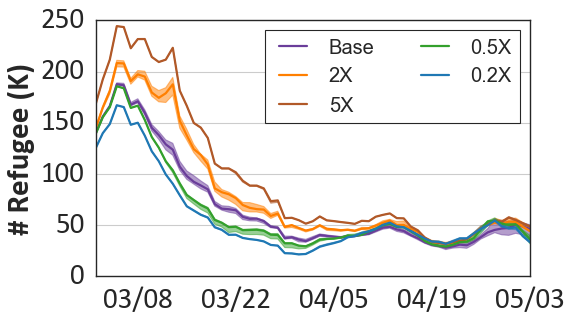

In [192]:
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

trim = 7

somewhat_hi = [90055,90015,90105,90075,90025] #[100,1000,2000,5000,10000]
very_hi = [90085,90035,90045,90065,90095] #[50000,1e5,1e6,1e7,5e7]
somewhat_lo = [90016,90106,90026,90076,90036] #[1e-2,2e-2,1e-3,5e-4,1e-5]
very_lo = [90066,90046,90056,90086,90096] #[1e-8,1e-6,1e-7,5e-6,5e-8or something]

Q1 = 0.2
Q3 = 0.8

m_base,q1_base,q3_base = get_uncertainty(simulation_indices_base,first_df,q1=Q1,q3=Q3)

m_hi_1,q1_hi_1,q3_hi_1 = get_uncertainty(somewhat_hi,first_df,q1=Q1,q3=Q3)
m_hi_2,q1_hi_2,q3_hi_2 = get_uncertainty(very_hi,first_df,q1=Q1,q3=Q3)

m_lo_1,q1_lo_1,q3_lo_1 = get_uncertainty(somewhat_lo,first_df,q1=Q1,q3=Q3)
m_lo_2,q1_lo_2,q3_lo_2 = get_uncertainty(very_lo,first_df,q1=Q1,q3=Q3)

fig,ax = plt.subplots(figsize=(7,4))
#plt.xticks(rotation=15)

#ax.plot(refugee_data_2['time'], refugee_data_2['refugee']/1000,label='Observed',linewidth=4,color='#006d2c')

sns.set_style('white')

SHIFT = -1
ax.plot(first_df['time'],m_base/1000,linewidth=2,color='#6a3d9a',alpha=1,label='Base')
ax.fill_between(first_df["time"], q1_base/1000, q3_base/1000, color='#6a3d9a',alpha=0.5)
ax.plot(first_df['time'],m_hi_1/1000,linewidth=2,color='#ff7f00',alpha=1,label='2X')
ax.fill_between(first_df["time"], q1_hi_1/1000, q3_hi_1/1000, color='#ff7f00',alpha=0.5)
ax.plot(first_df['time'],m_hi_2/1000,linewidth=2,color='#b15928',alpha=1,label='5X')
ax.fill_between(first_df["time"], q1_hi_2/1000, q3_hi_2/1000, color='#b15928',alpha=0.5)
ax.plot(first_df['time'],m_lo_1/1000,linewidth=2,color='#33a02c',alpha=1,label='0.5X')
ax.fill_between(first_df["time"], q1_lo_1/1000, q3_lo_1/1000, color='#33a02c',alpha=0.5)
ax.plot(first_df['time'],m_lo_2/1000,linewidth=2,color='#1f78b4',alpha=1,label='0.2X')
ax.fill_between(first_df["time"], q1_lo_2/1000, q3_lo_2/1000, color='#1f78b4',alpha=0.5)

#ax.plot(first_df['time'][0:SHIFT],median_normal.shift(SHIFT)[0:SHIFT]/1000,linewidth=2,color='#6a51a3',alpha=1,label='ABM-NA')
#ax.fill_between(first_df["time"][0:SHIFT], q1_normal.shift(SHIFT)[0:SHIFT]/1000, q3_normal.shift(SHIFT)[0:SHIFT]/1000, color='#9e9ac8',alpha=0.8)
#ax.plot(first_df_state['time'],median_normal_state/1000,linewidth=2,color='#b35806',alpha=1,label='Pandey et al.')
#ax.fill_between(first_df_state['time'], q1_normal_state/1000, q3_normal_state/1000, color='#e08214',alpha=0.5)
#ax.plot(first_df['time'],median_normal/1000,linewidth=2,color='red',alpha=0.1,label='ABM')
#ax.fill_between(first_df["time"], q1_normal/1000, q3_normal/1000, color='red',alpha=0.1)

myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)

#ax.set_facecolor("white")
sns.set_style('white')
#ax.annotate('RMSPE = 0.23', xy=(19100, 120),fontsize=20,fontweight='bold')
#ax.annotate('PCC = 0.98', xy=(19100, 100),fontsize=20,fontweight='bold')
ax.legend(loc='best',ncol=2,fontsize=18)
ax.set_ylabel("# Refugee (K)",fontweight='bold')
ax.set_xlim([datetime.date(2022, 3, 2), datetime.date(2022, 5, 3)])
#ax.set_ylim([0,300])
ax.grid(axis='y')
print(ax.get_xticks())
fig.savefig('../Figures/aamas_case_study.png',dpi=350,bbox_inches='tight')
fig.tight_layout()

#5110 porjonto bhalo

In [52]:
import datetime

trim = 7

#good = []

median_normal,q1_normal,q3_normal = get_uncertainty(simulation_indices,first_df,q1=0.35,q3=0.65)
median_normal_state,q1_normal_state,q3_normal_state = get_uncertainty(simulation_indices_state,first_df_state,q1=0.35,q3=0.65)
# median_esc,q1_esc,q3_esc = get_uncertainty(simulation_indices[10:-trim],first_df)

# median_normal_unsmooth,q1_normal_unsmooth,q3_normal_unsmooth = get_uncertainty(simulation_indices[0:10-trim],second_df)
# median_esc_unsmooth,q1_esc_unsmooth,q3_esc_unsmooth = get_uncertainty(simulation_indices[10:-trim],second_df)

# median_normal,q1_normal,q3_normal = get_uncertainty([check_single],first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty([check_single+1],first_df)
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(8,5))
plt.xticks(rotation=15)

#ax.plot(refugee_data['time'], refugee_data['refugee']/1000,label='Observed',linewidth=4,color='#41ab5d')
#ax.plot(refugee_data_full['time'], refugee_data_full['refugee']/1000,label='Observed 2',linewidth=8,color='black')
ax.plot(refugee_data_2['time'], refugee_data_2['refugee']/1000,label='Observed',linewidth=4,color='#006d2c')
#l_vals = [-0.1,0.5,0.6,0.7,0.8,0.9]
#l_vals = [0.1,0.05,0.01,0.001,0.2]
#l_vals = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.01,0.99]
l_vals = simulation_indices
#l_vals = [0.9,0.8,0.2,0.5]
for idx,p in enumerate(simulation_indices):
    print(p,end=' ')
    try:
        new_series = first_df[str(p)].copy()
        #if new_series.max()>250000:
        #    continue
        #if new_series[0:10].min()<100000:
        #    continue
        #ax.plot(first_df['time'],new_series/1000,linewidth=2,alpha=0.8)
    except Exception as e:
        print(e)
        continue
sns.set_style('white')
SHIFT = -1
#ax.plot(first_df['time'][0:SHIFT],median_normal.shift(SHIFT)[0:SHIFT]/1000,linewidth=2,color='#6a51a3',alpha=1,label='ABM-Agency',marker='x')
#ax.fill_between(first_df["time"][0:SHIFT], q1_normal.shift(SHIFT)[0:SHIFT]/1000, q3_normal.shift(SHIFT)[0:SHIFT]/1000, color='#9e9ac8',alpha=0.8)
ax.plot(first_df_state['time'],median_normal_state/1000,linewidth=2,color='#b35806',alpha=1,label='ABM-IA')
ax.fill_between(first_df_state['time'], q1_normal_state/1000, q3_normal_state/1000, color='#e08214',alpha=0.8)
#ax.plot(first_df['time'],median_normal/1000,linewidth=2,color='red',alpha=0.1,label='ABM')
#ax.fill_between(first_df["time"], q1_normal/1000, q3_normal/1000, color='red',alpha=0.1)

myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)
ax.annotate('RMSPE = 0.77', xy=(19100, 200),fontsize=20,fontweight='bold')
ax.annotate('PCC = 0.94', xy=(19100, 150),fontsize=20,fontweight='bold')
#ax.set_facecolor("white")
sns.set_style('whitegrid')

ax.legend(loc='best',ncol=1,fontsize=18)
ax.set_ylabel("# Refugee (K)",fontweight='bold')
ax.set_xlim([datetime.date(2022, 3, 2), datetime.date(2022, 5, 15)])
#ax.set_ylim([0,300])
ax.grid(axis='x')
#print(ax.get_xticks())
fig.tight_layout()
fig.savefig('../Figures/aamas_sofa_result.pdf',dpi=350,bbox_inches='tight')
#5110 porjonto bhalo

NameError: name 'simulation_indices_state' is not defined

In [29]:
top_20_indices = [20089, 20042, 20074, 20058, 20037, 20025, 20095, 20059, 20063, 20082, 20048, 20013, 20019, 20026, 20070, 20012, 20072, 20016, 20071, 20099]

In [69]:
first_df['m_base'] = m_base
first_df['q1_base'] = q1_base
first_df['q3_base'] = q3_base

first_df['m_hi_1'] = m_hi_1
first_df['q1_hi_1'] = q1_hi_1
first_df['q3_hi_1'] = q3_hi_1

first_df['m_hi_2'] = m_hi_2
first_df['q1_hi_2'] = q1_hi_2
first_df['q3_hi_2'] = q3_hi_2

first_df['m_lo_1'] = m_lo_1
first_df['q1_lo_1'] = q1_lo_1
first_df['q3_lo_1'] = q3_lo_1

first_df['m_lo_2'] = m_lo_2
first_df['q1_lo_2'] = q1_lo_2
first_df['q3_lo_2'] = q1_lo_2
compare_df = first_df.merge(refugee_data_2,on='time',how='inner')

In [161]:
start = pd.to_datetime('2022-03-01')
end = pd.to_datetime('2022-03-31')

intensity = ['lo_2','lo_1','base','hi_1','hi_2']
label = ['0.2x','0.5x','Base','2x','5x']
xs = [0.2,0.5,1,2,5]
x = []
y_1 = []
y_errmin = []
y_errmax = []

colors = ['#6a3d9a','#bf812d','#543005','#35978f','#003c30']

for idx,intense in enumerate(intensity):
    x.append(label[idx])
    m = compare_df[(compare_df.time>=start) & (compare_df.time<=end)]['m_'+intense].sum()/1000000
    q1 = compare_df[(compare_df.time>=start) & (compare_df.time<=end)]['q1_'+intense].sum()/1000000
    q3 = compare_df[(compare_df.time>=start) & (compare_df.time<=end)]['q3_'+intense].sum()/1000000
    #err = [m-q1,q3-m]
    y_1.append(m)
    y_errmin.append(m-q1)
    y_errmax.append(q3-m)

start = pd.to_datetime('2022-04-08')
end = pd.to_datetime('2022-05-01')

y_2 = []


for idx,intense in enumerate(intensity):
    #x.append(label[idx])
    m = compare_df[(compare_df.time>=start) & (compare_df.time<=end)]['m_'+intense].sum()/1000000
    q1 = compare_df[(compare_df.time>=start) & (compare_df.time<=end)]['q1_'+intense].sum()/1000000
    q3 = compare_df[(compare_df.time>=start) & (compare_df.time<=end)]['q3_'+intense].sum()/1000000
    #err = [m-q1,q3-m]
    y_2.append(m)
    #y_errmin.append(m-q1)
    #y_errmax.append(q3-m)


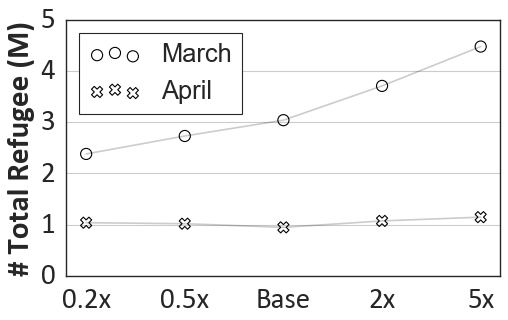

In [194]:
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
import math
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(7,4))

minimum_ele = min(y_2)
maximum_ele = max(y_1)
new_list = range(math.floor(minimum_ele), math.ceil(maximum_ele)+1)

sns.set_style('white')
ax.scatter(x,y_1,marker='o',s=100,facecolors='none',edgecolors='black',label='March')
ax.plot(x,y_1,color='black',alpha=0.2)
ax.scatter(x,y_2,marker='X',s=100,facecolors='none',edgecolors='black',label='April')
ax.plot(x,y_2,color='black',alpha=0.2)
#ax.errorbar(x, y,yerr=y_errs,fmt='o', color="r")  # you can use color ="r" for red or skip to default as blue
ax.set_ylabel("# Total Refugee (M)",fontweight='bold')
#ax.set_xlabel("Intensity compared to Base",fontweight='bold')
ax.grid(axis='y')
ax.set_yticks(new_list)
ax.legend(loc='best',fontsize=23)

fig.savefig('../Figures/AAMAS_case_March_April.png',dpi=350,bbox_inches='tight')
#fig.tight_layout()

In [133]:
y

[3.041426247070676,
 3.7105210904706243,
 4.479235243838977,
 2.732494825022804,
 2.3817609246947753]

In [130]:
0.18/1.22 -- 1.4

0.1487603305785124

In [131]:
0.3/1.22 -- 1.52

0.24793388429752067

In [139]:
(3.71-3.0)/3.04

0.23355263157894735

In [137]:
(4.48-3.04)/3.04

0.47368421052631593

In [33]:
# compare_df['median'] = compare_df['median'].shift(-2)
# compare_df['q1'] = compare_df['q1'].shift(-2)
# compare_df['q3'] = compare_df['median'].shift(-2)
# for pp in simulation_indices:
#     compare_df[str(pp)] = compare_df[str(pp)].shift(-2)
# compare_df = compare_df.dropna(subset=['median'])

In [34]:
pcc = compare_df['median'].corr(compare_df['refugee'])
print(pcc)
mse = ((((compare_df['median'] - compare_df['refugee'])/compare_df['refugee'])**2).sum()/compare_df.shape[0])**0.5
print(mse)

0.9815663646970235
0.23627916847055977


In [35]:
mase_nom = (abs(compare_df['median'] - compare_df['refugee'])).sum()/compare_df.shape[0]
mase_denom = (abs(compare_df['refugee'].diff().dropna()).sum())/(compare_df.shape[0]-1)
print(mase_nom,mase_denom)
mase = mase_nom/mase_denom
print(mase)

10216.481861958266 2726.1233766233763
3.747622704667379


In [36]:
pcc = compare_df['median_state'].corr(compare_df['refugee'])
print(pcc)
mse = ((((compare_df['median_state'] - compare_df['refugee'])/compare_df['refugee'])**2).sum()/compare_df.shape[0])**0.5
print(mse)

0.9376642788120213
0.7046751813005158


In [37]:
mase_nom = (abs(compare_df['median_state'] - compare_df['refugee'])).sum()/compare_df.shape[0]
mase_denom = (abs(compare_df['refugee'].diff().dropna()).sum())/(compare_df.shape[0]-1)
print(mase_nom,mase_denom)
mase = mase_nom/mase_denom
print(mase)

47559.81741212125 2726.1233766233763
17.44595194038124


In [38]:
mase_nom = (abs(compare_df['median'] - compare_df['refugee'])).sum()/compare_df.shape[0]
mase_denom = (abs(compare_df['refugee'].diff().dropna()).sum())/(compare_df.shape[0]-1)
mase = mase_nom/mase_denom
print(mase)

3.747622704667379


In [39]:
# metric_df = pd.DataFrame(columns=['run_idx','mse','pcc'])

# all_pccs = []
# for pp in simulation_indices:
#     pcc = compare_df[str(pp)].corr(compare_df['refugee'])
#     mse = (((compare_df[str(pp)] - compare_df['refugee'])**2).sum()/compare_df.shape[0])**0.5
#     #print(pp,pcc,mse)
#     metric_df = metric_df.append({'run_idx':pp,'mse':mse,'pcc':pcc},ignore_index=True)
# metric_df

In [40]:
# print(metric_df.sort_values(by=['mse']).head(20)['run_idx'].astype(int).tolist())

## Analyze results from LHS

### first gather all the parameter space covered by LHS

In [41]:
def get_params_from_file(filename):
    with open(filename,'r') as f:
        line = f.readlines()[0]
        args = line.split()
        #print(args)
        param_dict = {'D':float(args[6]),'A':float(args[7]),'T':float(args[8]),'S':float(args[9]),'t_r':int(args[10]),'beta_1':float(args[12]),'beta_2':float(args[13]),
                      'pi_lo':float(args[15]),'pi_hi':float(args[16]),'lambda_1':float(args[17]),'lambda_2':1-float(args[17]),'b_prob':float(args[20]),'p_iter':int(args[25])}
    f.close()
    return param_dict


all_params = []

for i in range(20000,20100):
    filename = "LHS_SAMPLE_"+str(i)+".sh"
    param_dict = get_params_from_file(filename)
    param_dict['hyper_comb'] = i
    all_params.append(param_dict)
    
lhs_param_df = pd.DataFrame.from_dict(all_params)
lhs_param_df

,D,A,T,S,t_r,beta_1,beta_2,pi_lo,pi_hi,lambda_1,lambda_2,b_prob,p_iter,hyper_comb
0,2.831176,45.411820,2.422179,46.541909,3,0.686638,0.289037,0.094940,0.490262,0.740918,0.259082,0.335076,2,20000
1,4.435379,33.604361,2.634121,73.349321,8,0.905011,0.784056,0.066045,0.882867,0.589244,0.410756,0.331213,3,20001
2,4.764692,69.648080,1.007723,9.495490,3,0.782222,0.220737,0.027456,0.838665,0.710443,0.289557,0.356115,2,20002
3,4.187796,48.987643,1.695427,13.706125,3,0.185530,0.166866,0.098938,0.651743,0.453513,0.546487,0.250919,4,20003
4,1.302256,66.268281,2.977944,4.568763,6,0.514779,0.077862,0.075313,0.542286,0.088325,0.911675,0.396552,4,20004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.071038,52.681946,2.340896,35.576832,6,0.918551,0.592917,0.055133,0.710004,0.776974,0.223026,0.308212,4,20095
96,1.446312,51.467685,2.808122,26.582585,3,0.874078,0.055457,0.071429,0.981925,0.480247,0.519753,0.399639,3,20096
97,1.607279,65.146913,2.319547,5.118949,9,0.482696,0.487503,0.062982,0.483367,0.095907,0.904093,0.389809,1,20097
98,3.039288,45.078870,1.892342,54.889223,4,0.968533,0.353620,0.053599,0.964687,0.909797,0.090203,0.391651,3,20098


In [42]:
def get_params_from_file(filename):
    with open(filename,'r') as f:
        line = f.readlines()[0]
        args = line.split()
        #print(args)
        param_dict = {'D':float(args[6]),'A':float(args[7]),'T':float(args[8]),'S':float(args[9]),'t_r':int(args[10]),'beta_1':float(args[12]),'beta_2':float(args[13]),
                      'pi_lo':float(args[15]),'pi_hi':float(args[16]),'lambda_1':float(args[17]),'lambda_2':1-float(args[17]),'b_prob':float(args[20]),'p_iter':int(args[25])}
    f.close()
    return param_dict

print(get_params_from_file('LHS_SAMPLE_20074.sh'))
print(get_params_from_file('LHS_SAMPLE_20042.sh'))
print(get_params_from_file('LHS_SAMPLE_20089.sh'))

{'D': 2.18663941021782, 'A': 37.060756808501864, 'T': 1.0348449500885029, 'S': 57.91356700688765, 't_r': 6, 'beta_1': 0.1781240295913104, 'beta_2': 0.8762308137940877, 'pi_lo': 0.09264433888912414, 'pi_hi': 0.6674105660199474, 'lambda_1': 0.4980495151203558, 'lambda_2': 0.5019504848796442, 'b_prob': 0.32547145503549796, 'p_iter': 4}
{'D': 3.873008070488465, 'A': 43.19473040158702, 'T': 2.835951249156568, 'S': 15.2320047494748, 't_r': 8, 'beta_1': 0.13543593439692808, 'beta_2': 0.8106345404649975, 'pi_lo': 0.02561506076832155, 'pi_hi': 0.4479652516707181, 'lambda_1': 0.14745980455382662, 'lambda_2': 0.8525401954461733, 'b_prob': 0.2567658397968005, 'p_iter': 3}
{'D': 4.013392668224993, 'A': 35.54586082550363, 'T': 2.8572254156167416, 'S': 31.813902706057913, 't_r': 4, 'beta_1': 0.6724382292457873, 'beta_2': 0.8574135208163113, 'pi_lo': 0.017421250888280622, 'pi_hi': 0.9899915466653364, 'lambda_1': 0.36774379606348145, 'lambda_2': 0.6322562039365185, 'b_prob': 0.2405191926581789, 'p_iter

### gather outputs of interest for each parameter space
### outputs of interest: total migration, migration in march, migration in april, migration in may, max migration one day

In [43]:
all_outputs = []

for pp in simulation_indices:
    
    tot_migration = compare_df[str(pp)].sum()
    march_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))][str(pp)].sum()
    april_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))][str(pp)].sum()
    may_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-05-01')) & (compare_df.time<=pd.to_datetime('2022-05-31'))][str(pp)].sum()
    max_migration = compare_df[str(pp)].max()
    
    ob_tot_migration = compare_df['refugee'].sum()
    ob_march_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['refugee'].sum()
    ob_april_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['refugee'].sum()
    ob_may_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-05-01')) & (compare_df.time<=pd.to_datetime('2022-05-31'))]['refugee'].sum()
    ob_max_migration = compare_df[str(pp)].max()
    
    output_dict = {'hyper_comb':pp,'output_tot':tot_migration,'output_MAR':march_migration,'output_APR':april_migration,'output_MAY':may_migration,'output_MAX':max_migration,
                  'obs_tot':ob_tot_migration,'obs_MAR':ob_march_migration,'obs_APR':ob_april_migration,'obs_MAY':ob_may_migration,'obs_MAX':ob_max_migration}
    all_outputs.append(output_dict)
    
output_df = pd.DataFrame.from_dict(all_outputs)
#output_df

## merge the two dataframes for sensitivity analysis

In [44]:
output_vs_param_df = lhs_param_df.merge(output_df,on='hyper_comb',how='inner')
#output_vs_param_df

In [49]:
param_names = lhs_param_df.columns.tolist()[0:-1]
param_names.remove('t_r')
param_names.remove('lambda_2')
param_names.remove('beta_2')
param_names.remove('b_prob')
param_names.remove('p_iter')

outputs_of_interest = output_df.columns.tolist()[1:6]
outputs_observed = output_df.columns.tolist()[6:11]
outputs_of_interest.remove('output_MAY')
outputs_observed.remove('obs_MAY')

In [50]:
input_mapping = {'D':'$\\delta$','A':'Q','S':'$\\theta$','T':'$\\tau$','t_r':'$\\alpha$','beta_1':'$\\beta$','beta_2':'$\\beta2$',
                 'pi_lo':'$\\pi^{\\downarrow}$','pi_hi':'$\\pi$','lambda_1':'$\\lambda$','lambda_2':'$\\alpha$','p_iter':'Hop','b_prob':'$\\alpha$'}

In [51]:
#print(r'$\alpha_i > \beta_i$')

## create scatter plot for each output of interest and each single parameter

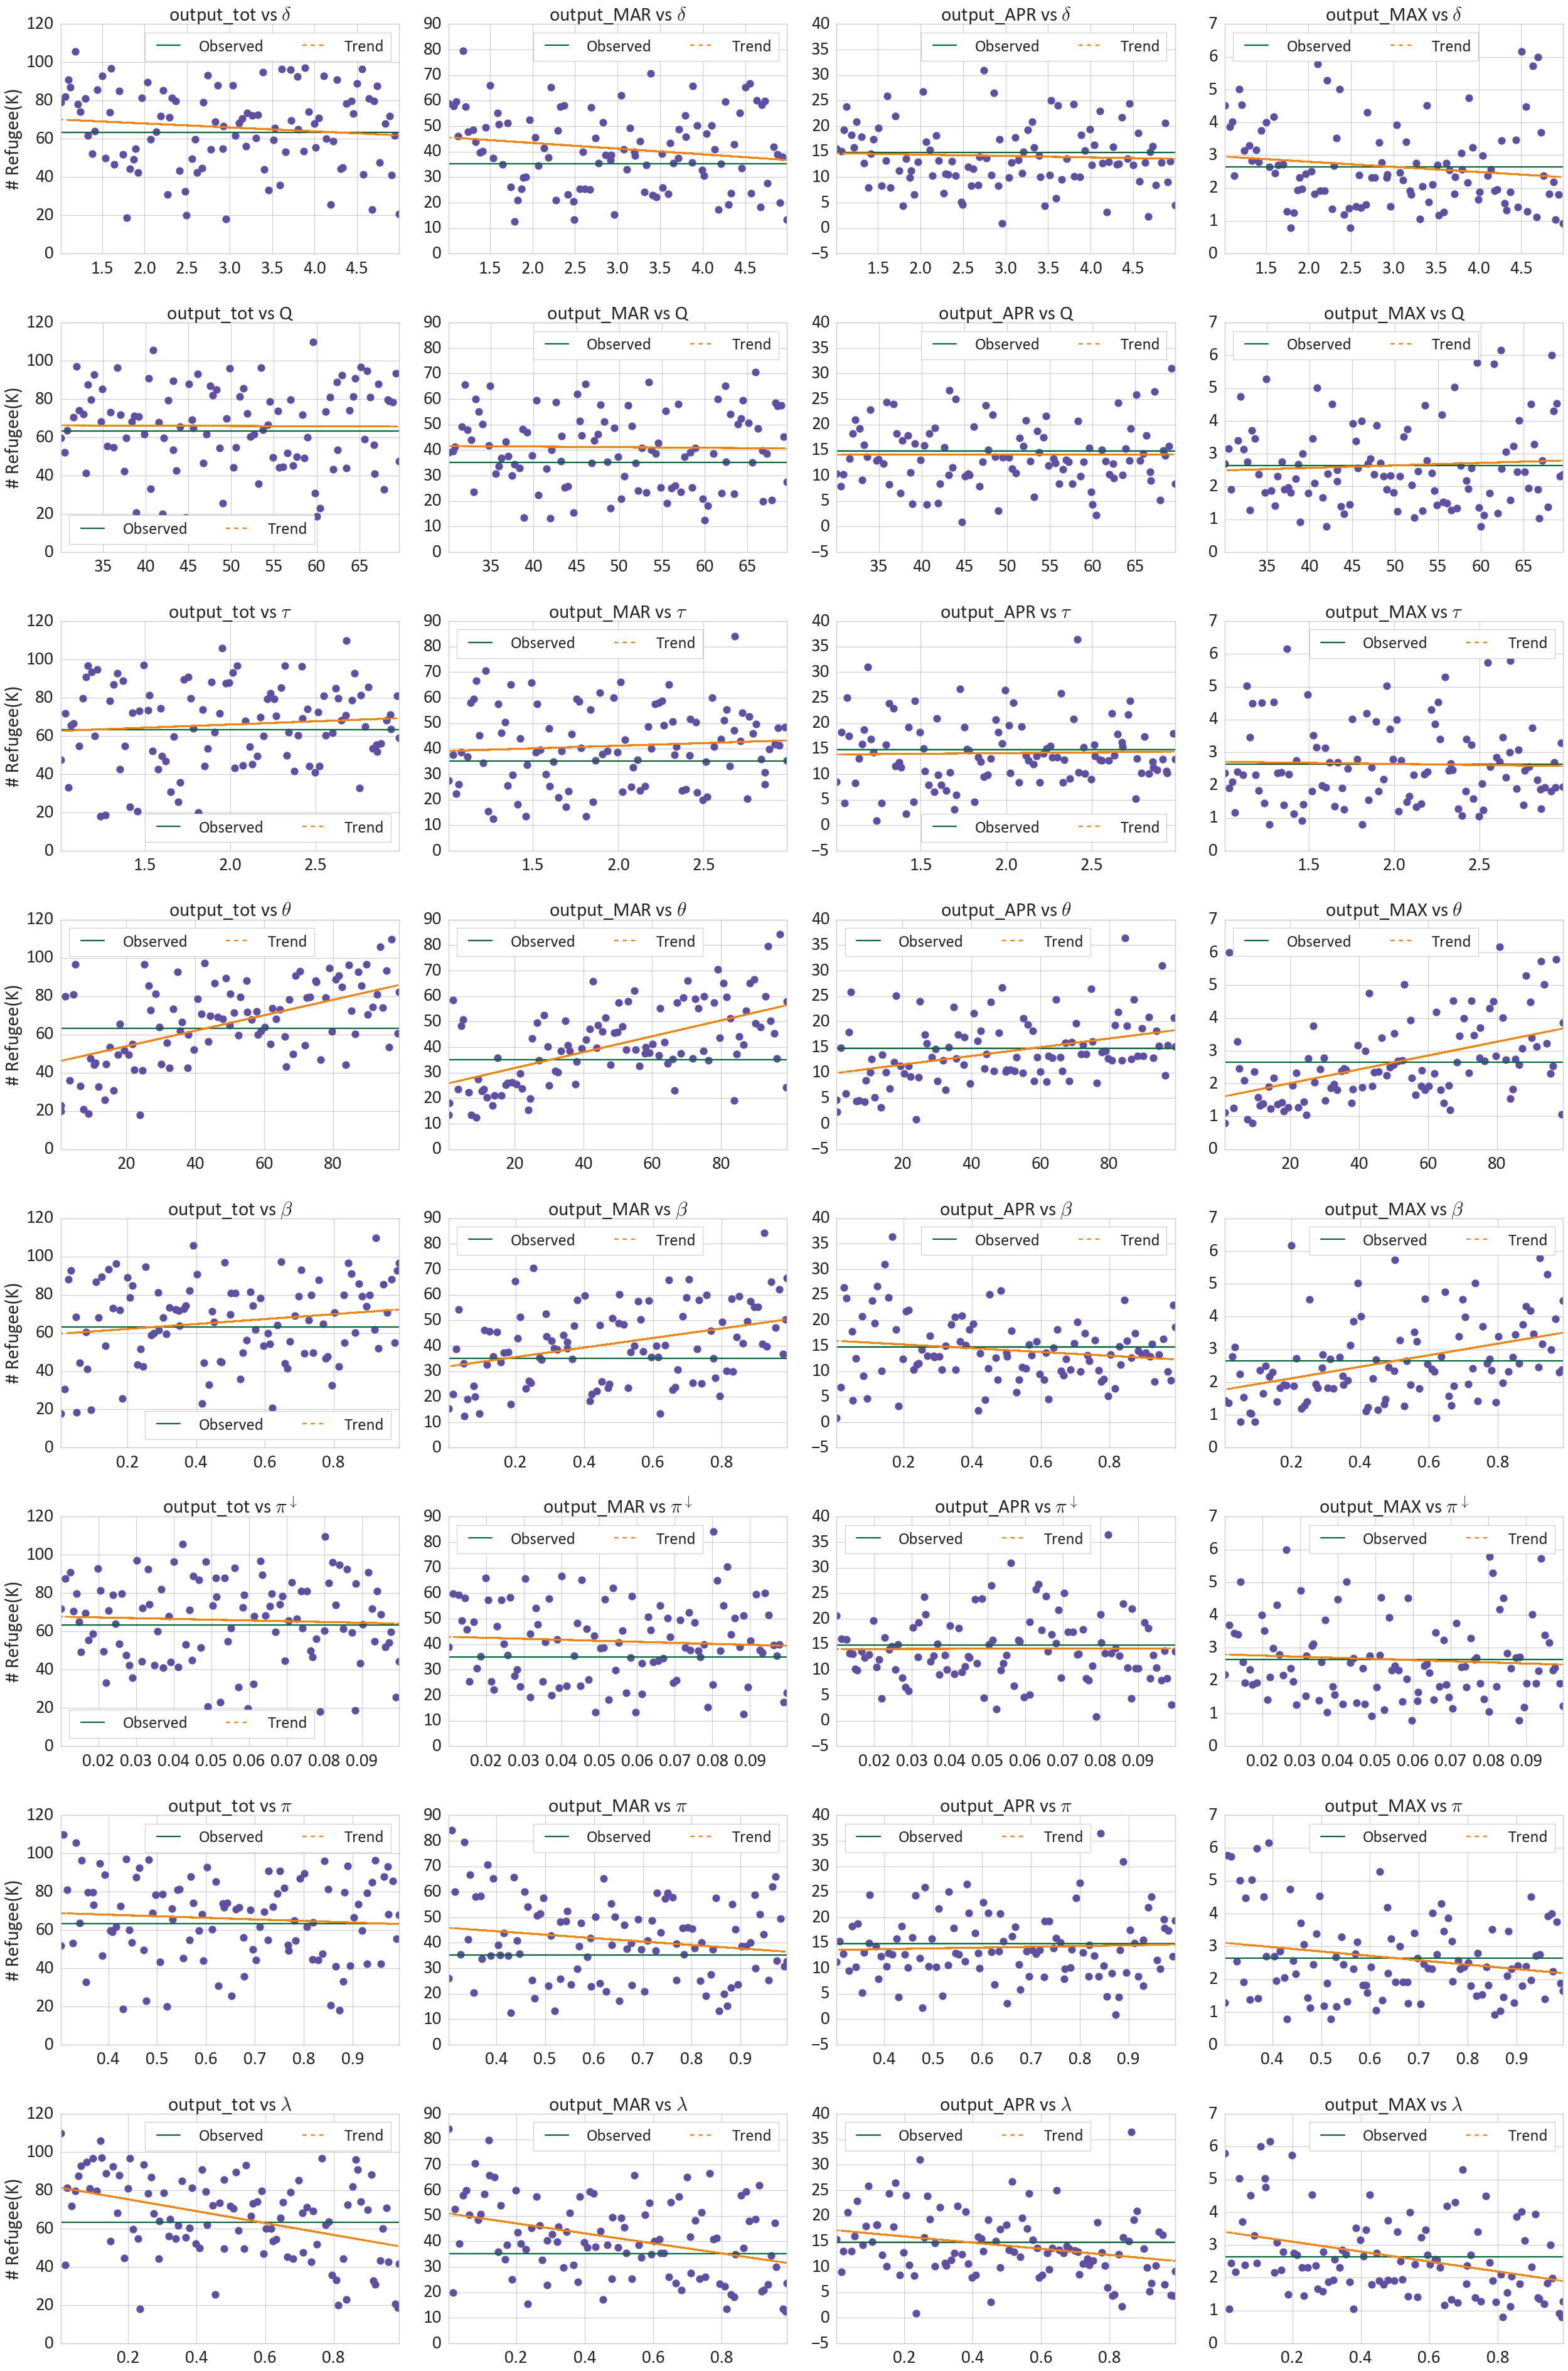

In [52]:
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(len(param_names),len(outputs_of_interest),figsize=(8*len(outputs_of_interest),6*len(param_names)))

for i,param in enumerate(param_names):
    for j,out in enumerate(outputs_of_interest):
        ax[i][j].scatter(output_vs_param_df[param],output_vs_param_df[out]/100000,s=100,color='#5e4fa2')
        ax[i][j].set_title(out+' vs '+input_mapping[param],fontsize=28)
        
        ax[i][j].axhline(y=output_vs_param_df[outputs_observed[j]].mean()/100000,color='#006837',label='Observed',linewidth=2)
        ax[i][j].set_xlim([output_vs_param_df[param].min(),output_vs_param_df[param].max()])
        if(j==0):
            ax[i][j].set_ylabel('# Refugee(K)')
        z = np.polyfit(output_vs_param_df[param],output_vs_param_df[out]/100000,1)
        p = np.poly1d(z)
        ax[i][j].plot(output_vs_param_df[param],p(output_vs_param_df[param]),"r--",label='Trend',color='#ff7f00',linewidth=2)
        ax[i][j].legend(loc='best',fontsize=24,ncol=2)
fig.tight_layout()

In [53]:
import pingouin as pg

prcc_dict_pearson = []
prcc_dict_spearman = []

for output in outputs_of_interest:
    for param in param_names:
        covs = [p for p in param_names if p!=param]
        #print(param,output)
        cur_df_pearson = pg.partial_corr(data=output_vs_param_df, x=param, y=output, covar=covs).round(20)
        #print(covs)
        #if cur_df_pearson['p-val'].mean()<0.05:
            #print('Pearson',param,output,'r=',cur_df_pearson['r'].mean(),'CI95%=',cur_df_pearson['CI95%'].mean(),'p-val=',cur_df_pearson['p-val'].mean())
        
        new_row_pearson = {'Param':input_mapping[param],'Output':output,'PRCC':cur_df_pearson['r'].mean(),'CI95%':cur_df_pearson['CI95%'].mean(),'p-value':cur_df_pearson['p-val'].mean()}
        cur_df_pearson = pg.partial_corr(data=output_vs_param_df, x=param, y=output, covar=covs,method='spearman').round(7)
        #print(covs)
        #if cur_df_pearson['p-val'].mean()<0.05:
            #print('Spearman',param,output,'r=',cur_df_pearson['r'].mean(),'CI95%=',cur_df_pearson['CI95%'].mean(),'p-val=',cur_df_pearson['p-val'].mean())
            
        new_row_spearman = {'Param':input_mapping[param],'Output':output,'PRCC':cur_df_pearson['r'].mean(),'CI95%':cur_df_pearson['CI95%'].mean(),'p-value':cur_df_pearson['p-val'].mean()}
        #print('')
        prcc_dict_pearson.append(new_row_pearson)
        prcc_dict_spearman.append(new_row_spearman)
        
prcc_df_pearson = pd.DataFrame.from_dict(prcc_dict_pearson)
prcc_df_spearman = pd.DataFrame.from_dict(prcc_dict_spearman)

In [54]:
param_names

['D', 'A', 'T', 'S', 'beta_1', 'pi_lo', 'pi_hi', 'lambda_1']

In [55]:
pearson_by_output_type = [x for _, x in prcc_df_pearson.groupby('Output')]
pearson_by_ = [y for y, x in prcc_df_pearson.groupby('Output')]

for i in range(0,len(pearson_by_output_type)):
    all_cols = pearson_by_output_type[i].columns.tolist()
    for col in all_cols:
        #print(col)
        if col=='Param':
            continue
        if col=='Output':
            continue
        #print(col)
        pearson_by_output_type[i] = pearson_by_output_type[i].rename(columns={col:col+' for '+pearson_by_[i]})
    print('')
    pearson_by_output_type[i] = pearson_by_output_type[i].drop(columns=['Output'])

rearranged_df = pearson_by_output_type[0]

for df in pearson_by_output_type[1:]:
    rearranged_df = rearranged_df.merge(df,on='Param',how='inner')

coloring_columns = [c for c in rearranged_df.columns.tolist() if c.startswith('p-value')]
print(coloring_columns)
rearranged_df = rearranged_df.style.applymap(lambda x: "background-color: #fb9a99" if x<0.05 else "background-color: white",subset=coloring_columns)
rearranged_df





['p-value for output_APR', 'p-value for output_MAR', 'p-value for output_MAX', 'p-value for output_tot']


,Param,PRCC for output_APR,CI95% for output_APR,p-value for output_APR,PRCC for output_MAR,CI95% for output_MAR,p-value for output_MAR,PRCC for output_MAX,CI95% for output_MAX,p-value for output_MAX,PRCC for output_tot,CI95% for output_tot,p-value for output_tot
0,$\delta$,-0.051793,[-0.25 0.15],0.621977,-0.241123,[-0.42 -0.04],0.019895,-0.232075,[-0.42 -0.03],0.025193,-0.138975,[-0.33 0.07],0.183994
1,Q,-0.006414,[-0.21 0.2 ],0.951347,-0.023605,[-0.23 0.18],0.822296,0.106000,[-0.1 0.3],0.311894,-0.018164,[-0.22 0.19],0.862800
2,$\tau$,-0.002785,[-0.21 0.2 ],0.978860,0.029677,[-0.18 0.23],0.777646,-0.136368,[-0.33 0.07],0.192440,0.055282,[-0.15 0.26],0.598671
3,$\theta$,0.392301,[0.2 0.55],0.000101,0.636915,[0.5 0.74],0.000000,0.563303,[0.41 0.69],0.000000,0.564579,[0.41 0.69],0.000000
4,$\beta$,-0.184539,[-0.37 0.02],0.076593,0.513651,[0.35 0.65],0.000000,0.550653,[0.39 0.68],0.000000,0.266620,[0.07 0.45],0.009784
5,$\pi^{\downarrow}$,-0.052920,[-0.25 0.15],0.614407,0.195750,[-0.01 0.38],0.060046,-0.128160,[-0.32 0.08],0.220850,-0.022476,[-0.23 0.18],0.830664
6,$\pi$,0.128565,[-0.08 0.32],0.219383,-0.174823,[-0.37 0.03],0.093726,-0.239559,[-0.42 -0.04],0.020736,0.002363,[-0.2 0.21],0.982066
7,$\lambda$,-0.265623,[-0.45 -0.07],0.010072,-0.458852,[-0.61 -0.28],0.000004,-0.425648,[-0.58 -0.24],0.000021,-0.463002,[-0.61 -0.29],0.000003


In [63]:
import pingouin as pg

prcc_dict_pearson = []
prcc_dict_spearman = []

param_names = ['D','S', 'beta_1', 'A', 'T', 'pi_hi', 'lambda_1']

for output in outputs_of_interest:
    for param in param_names:
        covs = [p for p in param_names if p!=param]
        #print(param,output)
        cur_df_pearson = pg.partial_corr(data=output_vs_param_df, x=param, y=output, covar=covs).round(20)
        #print(covs)
        #if cur_df_pearson['p-val'].mean()<0.05:
            #print('Pearson',param,output,'r=',cur_df_pearson['r'].mean(),'CI95%=',cur_df_pearson['CI95%'].mean(),'p-val=',cur_df_pearson['p-val'].mean())
        
        new_row_pearson = {'Param':input_mapping[param],'Output':output,'p-value':cur_df_pearson['p-val'].mean()}
        cur_df_pearson = pg.partial_corr(data=output_vs_param_df, x=param, y=output, covar=covs,method='spearman').round(7)
        #print(covs)
        #if cur_df_pearson['p-val'].mean()<0.05:
            #print('Spearman',param,output,'r=',cur_df_pearson['r'].mean(),'CI95%=',cur_df_pearson['CI95%'].mean(),'p-val=',cur_df_pearson['p-val'].mean())
            
        new_row_spearman = {'Param':input_mapping[param],'Output':output,'p-value':cur_df_pearson['p-val'].mean()}
        #print('')
        prcc_dict_pearson.append(new_row_pearson)
        prcc_dict_spearman.append(new_row_spearman)
        
prcc_df_pearson = pd.DataFrame.from_dict(prcc_dict_pearson)
prcc_df_spearman = pd.DataFrame.from_dict(prcc_dict_spearman)

In [64]:
pearson_by_output_type = [x for _, x in prcc_df_pearson.groupby('Output')]
pearson_by_ = [y for y, x in prcc_df_pearson.groupby('Output')]

output_mapping = {'output_tot':'ALL','output_MAR':'MAR','output_APR':'APR','output_MAX':'MAX'}

for i in range(0,len(pearson_by_output_type)):
    all_cols = pearson_by_output_type[i].columns.tolist()
    for col in all_cols:
        #print(col)
        if col=='Param':
            continue
        if col=='Output':
            continue
        #print(col)
        pearson_by_output_type[i] = pearson_by_output_type[i].rename(columns={col:output_mapping[pearson_by_[i]]})
    print('')
    pearson_by_output_type[i] = pearson_by_output_type[i].drop(columns=['Output'])

rearranged_df = pearson_by_output_type[0]

for df in pearson_by_output_type[1:]:
    rearranged_df = rearranged_df.merge(df,on='Param',how='inner')

coloring_columns = [output_mapping[key] for key in output_mapping]
print(coloring_columns)
#rearranged_df = rearranged_df.style.applymap(lambda x: "background-color: #fb9a99" if x<0.05 else "background-color: white",subset=coloring_columns)
#rearranged_df 





['ALL', 'MAR', 'APR', 'MAX']


In [65]:
rearranged_df = rearranged_df.set_index('Param')
rearranged_df = rearranged_df[['MAR','APR','ALL','MAX']]

In [66]:
rearranged_df.astype(float).round(5)

,MAR,APR,ALL,MAX
Param,,,,
$\delta$,0.01916,0.71194,0.18131,0.04766
$\theta$,0.00000,0.00010,0.00000,0.00000
$\beta$,0.00000,0.08509,0.00899,0.00000
Q,0.82038,0.97945,0.86161,0.27283
$\tau$,0.77642,0.96418,0.59655,0.17883
$\pi$,0.08784,0.19733,0.98176,0.02715
$\lambda$,0.00000,0.00957,0.00000,0.00002


In [67]:
rearranged_df.T

Param,$\delta$,$\theta$,$\beta$,Q,$\tau$,$\pi$,$\lambda$
MAR,0.019159,5.165620e-12,1.065770e-07,0.820381,0.776425,0.087844,0.000003
APR,0.711943,1.006041e-04,8.508705e-02,0.979452,0.964180,0.197326,0.009569
ALL,0.181308,3.092778e-09,8.989666e-03,0.861609,0.596554,0.981762,0.000002
MAX,0.047662,5.437820e-09,3.136722e-09,0.272833,0.178829,0.027146,0.000021


In [68]:
ps = []

for col in rearranged_df.T.columns.tolist():
    print(col,(rearranged_df.T)[col].mean())
    ps.append((rearranged_df.T)[col].mean())
    
ps.sort()
print(ps)

$\delta$ 0.24001798751996747
$\theta$ 2.5153167869667407e-05
$\beta$ 0.02351920728441998
Q 0.733568549630361
$\tau$ 0.6289970388946942
$\pi$ 0.32351952063887773
$\lambda$ 0.0023986967983693408
[2.5153167869667407e-05, 0.0023986967983693408, 0.02351920728441998, 0.24001798751996747, 0.32351952063887773, 0.6289970388946942, 0.733568549630361]


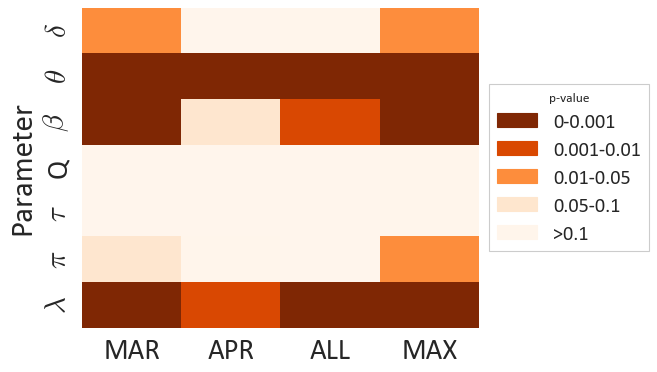

In [69]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
#['#f1eef6','#d7b5d8','#df65b0','#dd1c77','#980043']
#['#feedde','#fdd0a2','#fdae6b','#fd8d3c','#e6550d','#a63603']
colors = [[0, '#7f2704'],
          [0.0009999999,'#7f2705'],
          [0.001, '#d94801'],
          [0.0099999999, '#d94802'],
          [0.01, '#fd8d3c'],
          [0.0499999999, '#fd8d3d'],
          [0.05, '#fee6ce'],
          [0.0999999999, '#fee6cf'],
          [0.1, '#fff5eb'],
         [1, '#fff5ec']]

#colors = []

all_colors = ['#fff5eb','#fee6ce','#fd8d3c','#d94801','#7f2704']
all_colors.reverse()
diff_ranges = [(0, 0.001), (0.001, 0.01), (0.01, 0.05), (0.05, 0.1), (0.1,1)]

def diff_to_color(diff):
    if diff<0:
        return all_colors[0]
    for i, (d_min, d_max) in enumerate(diff_ranges):
        if d_min <= diff < d_max:
            return all_colors[i]
    return all_colors[-1]

# colors.append('#a63603')
# cur_list = rearranged_df.values.flatten().tolist()
# cur_list.sort()
# for val in cur_list:
#     colors.append([val,diff_to_color(val)])
# colors.append([1.0,'#ffffff'])
#colors.sort()

# Create a legend for the color scheme
legend_handles = []
legend_labels = []
for i, (diff_range, diff_color) in enumerate(zip(diff_ranges, all_colors)):
    legend_handles.append(plt.Rectangle((0, 0), 2, 2, color=diff_color))
    if i == len(diff_ranges) - 1:
        legend_labels.append(f'>{diff_range[0]}')
    #elif i==0:
    #    legend_labels.append(f'<{diff_range[1]}%')
    else:
        legend_labels.append(f'{diff_range[0]}-{diff_range[1]}')


cmap = LinearSegmentedColormap.from_list('', colors)

print(cmap)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

#fig,ax = plt.subplots(figsize=(8,5))

fig,ax = plt.subplots(figsize=(8,5))
sns.heatmap(rearranged_df, cmap=cmap,ax=ax,cbar=False)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(handles=legend_handles,labels=legend_labels,title='p-value',fontsize=18,loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend()
ax.set_ylabel('Parameter')
fig.savefig('../Figures/global_sensitivity_analysis.png',dpi=350,bbox_inches='tight')

In [108]:
colors

[[6.81443888e-12, '#a63603'],
 [3.77689061861e-09, '#a63603'],
 [4.87197365354e-09, '#a63603'],
 [6.09580736191e-09, '#a63603'],
 [1.2687563386609e-07, '#a63603'],
 [2.07772010907489e-06, '#a63603'],
 [4.41311343681051e-06, '#a63603'],
 [3.555259875896048e-05, '#a63603'],
 [8.919284850319206e-05, '#a63603'],
 [0.003876482937491727, '#e6550d'],
 [0.008142930871768423, '#e6550d'],
 [0.02017667242652628, '#fd8d3c'],
 [0.02764613822865664, '#fd8d3c'],
 [0.043079494343374734, '#fd8d3c'],
 [0.046359107126803877, '#fd8d3c'],
 [0.08958350824736883, '#fd8d3c'],
 [0.11322645503800916, '#fdbe85'],
 [0.17257210660925087, '#fdbe85'],
 [0.18730758291724783, '#fdbe85'],
 [0.19069075353622045, '#fdbe85'],
 [0.26977621559890885, '#fdbe85'],
 [0.5807032696381862, '#ffffff'],
 [0.6087667596334201, '#ffffff'],
 [0.6251714435525234, '#ffffff'],
 [0.7735801615211507, '#ffffff'],
 [0.7748014225111725, '#ffffff'],
 [0.8194325952399338, '#ffffff'],
 [0.8533300194183798, '#ffffff'],
 [0.9136383153943302, '#ffff

In [100]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Sample 2D NumPy array
data = np.random.randint(1, 101, size=(10, 10))  # Replace this with your own data

# Define custom color thresholds and corresponding colors
color_thresholds = [25, 50, 75, 100]
colors = ['blue', 'green', 'green', 'red']

# Create a custom colormap with repeated colors for specific ranges
cmap = ListedColormap(np.repeat(colors, np.diff(color_thresholds), axis=0))

# Create a mask for values outside the defined range
mask = np.zeros_like(data, dtype=bool)
for threshold in color_thresholds:
    mask |= (data > threshold)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data, annot=True, fmt='d', cmap=cmap, mask=mask, cbar=False, square=True)

# Customize the colorbar
colorbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ticks=[0.5, 1.5, 3.5, 5.5], aspect=10)
colorbar.set_ticklabels(['<25', '25-50', '50-75', '75-100'])

# Set axis labels and title
plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.title('Custom Heatmap with Defined Color Ranges')

# Show the plot
plt.show()


ValueError: operands could not be broadcast together with shape (4,) (3,)

In [76]:
pearson_by_

['output_APR', 'output_MAR', 'output_MAX', 'output_tot']

In [79]:
df = pearson_by_output_type[3]
df = df.style.applymap(lambda x: "background-color: #fb9a99" if x<0.05 else "background-color: white",subset=[df.columns.tolist()[-1]])
df

,Param,PRCC for output_MAX,CI95% for output_MAX,p-value for output_MAX
27,$\delta$,-0.237542,[-0.42 -0.03],0.022607
28,Q,0.107226,[-0.1 0.31],0.308988
29,$\tau$,-0.140070,[-0.34 0.07],0.182955
30,$\theta$,0.565224,[0.41 0.69],0.000000
31,$\beta$,0.545113,[0.38 0.67],0.000000
32,$\pi^{\downarrow}$,-0.137616,[-0.33 0.07],0.190823
33,$\pi^{\uparrow}$,-0.241295,[-0.43 -0.04],0.020497
34,$\lambda$,-0.414419,[-0.57 -0.23],0.000040
35,Hop,0.073743,[-0.13 0.27],0.484805


In [101]:
pg.partial_corr(data=df, x='x', y='y', covar='cv1').round(2)

,n,r,CI95%,p-val
pearson,30,0.57,"[0.25, 0.77]",0.0


In [107]:
pg.partial_corr(data=df, x='x', y='y', covar=['y','cv2','cv3']).round(10)

,n,r,CI95%,p-val
pearson,30,-0.094767,"[-0.46, 0.3]",0.638226


In [156]:
sum(all_mses)/len(all_mses)

26000.035190333296

In [157]:
np.std(all_mses)

1301.9169308224493

In [ ]:
(compare_df['median']-compare_df['refugee'])

In [61]:
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['median'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q1'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q3'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['refugee'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['median'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['refugee'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q1'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q3'].sum()
compare_df['q1'].sum()
compare_df['q3'].sum()

3400824.6428571427

## get raion/oblast/macro-region level estimate

In [37]:
def get_raion_total(raion,end_date,hyper_comb,prefix='fresh_calib_batch_simulation'):
    f_name = prefix+'_completed_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    f2_name = prefix+'_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    if os.path.isfile(OUTPUT_DIR+f_name):
        true_f_name = f_name
    elif os.path.isfile(OUTPUT_DIR+f2_name):
        true_f_name = f2_name
    else:
        return 0
    cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
    cur_df['time'] = pd.to_datetime(cur_df['time'])
    cur_df = cur_df[cur_df.time<=pd.to_datetime(end_date)]
    return cur_df['refugee'].sum()


len(burundi_gdf['ADM1_EN'].unique().tolist())

27

In [38]:
burundi_gdf['ADM1_EN'].unique()

array(['Autonomous Republic of Crimea', 'Vinnytska', 'Volynska',
       'Dnipropetrovska', 'Donetska', 'Zhytomyrska', 'Zakarpatska',
       'Zaporizka', 'Ivano-Frankivska', 'Kyivska', 'Kirovohradska',
       'Luhanska', 'Lvivska', 'Mykolaivska', 'Odeska', 'Poltavska',
       'Rivnenska', 'Sumska', 'Ternopilska', 'Kharkivska', 'Khersonska',
       'Khmelnytska', 'Cherkaska', 'Chernivetska', 'Chernihivska', 'Kyiv',
       'Sevastopol'], dtype=object)

In [48]:
gen_for = 'ADM1_EN'

In [49]:
idp_macro_map = pd.read_csv('idp_macro.csv')
burundi_macro = burundi_gdf[['ADM2_EN','ADM1_EN','geometry']].merge(idp_macro_map,left_on='ADM1_EN',right_on='Oblast',how='inner')
raion_displace = pd.DataFrame(columns=['ADM2_EN','displacement'])
hyper_comb = 20089
until = '2022-03-16'
for r in burundi_macro.ADM2_EN.unique().tolist():
    raion_displace = raion_displace.append({'ADM2_EN':r,'displacement':get_raion_total(r,until,hyper_comb,prefix='mim_result')*1.2*(0.7/0.3)},ignore_index=True)

burundi_macro_displace = burundi_macro.merge(raion_displace,on='ADM2_EN',how='inner')

macro_df = burundi_macro_displace.groupby(gen_for)['displacement'].sum().reset_index()

In [50]:
macro_df['displacement_percentage_abm'] = ((macro_df['displacement']/macro_df['displacement'].sum() )*100.0).astype(float).round(1)
macro_df = macro_df.drop(columns=['displacement'])
macro_df

,ADM1_EN,displacement_percentage_abm
0,Autonomous Republic of Crimea,0.2
1,Cherkaska,0.1
2,Chernihivska,4.8
3,Chernivetska,0.0
4,Dnipropetrovska,4.7
5,Donetska,13.5
6,Ivano-Frankivska,0.7
7,Kharkivska,7.6
8,Khersonska,1.7
9,Khmelnytska,0.2


In [51]:
def get_raion_total_sofa(raion,end_date,hyper_comb,prefix='fresh_calib_batch_simulation'):
    OUTPUT_DIR_OLD = BASE_DIR+'output_data/' 
    f_name = prefix+'_completed_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    f2_name = prefix+'_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    if os.path.isfile(OUTPUT_DIR_OLD+f_name):
        true_f_name = f_name
    elif os.path.isfile(OUTPUT_DIR_OLD+f2_name):
        true_f_name = f2_name
    else:
        return 0
    cur_df = pd.read_csv(OUTPUT_DIR_OLD+true_f_name)
    cur_df['time'] = pd.to_datetime(cur_df['time'])
    BORDER_CROSS_PROB = float(np.random.normal(0.32,0.02,1)[0])
    IDP_PROB = 1.0 - BORDER_CROSS_PROB
    #IDP_REFUGEE_PROB = 0.1
    cur_df['FD'] = cur_df['refugee']/BORDER_CROSS_PROB
    cur_df['IDP'] = cur_df['FD']*IDP_PROB
    cur_df = cur_df[cur_df.time<=pd.to_datetime(end_date)]
    return cur_df['IDP'].sum()
    
raion_displace_sofa = pd.DataFrame(columns=['ADM2_EN','displacement'])
hyper_comb = 80009
until = '2022-03-16'
for r in burundi_macro.ADM2_EN.unique().tolist():
    raion_displace_sofa = raion_displace_sofa.append({'ADM2_EN':r,'displacement':get_raion_total_sofa(r,until,hyper_comb,prefix='mim_result')*1.2*(0.7/0.3)},ignore_index=True)

burundi_macro_displace_sofa = burundi_macro.merge(raion_displace_sofa,on='ADM2_EN',how='inner')

macro_df_sofa = burundi_macro_displace_sofa.groupby(gen_for)['displacement'].sum().reset_index()
macro_df_sofa['displacement_percentage_pandey'] =(( macro_df_sofa['displacement']/macro_df_sofa['displacement'].sum() )*100.0).astype(float).round(1)
macro_df_sofa = macro_df_sofa.drop(columns=['displacement'])
macro_df_sofa

,ADM1_EN,displacement_percentage_pandey
0,Autonomous Republic of Crimea,0.9
1,Cherkaska,1.7
2,Chernihivska,3.5
3,Chernivetska,0.0
4,Dnipropetrovska,1.9
5,Donetska,21.4
6,Ivano-Frankivska,1.8
7,Kharkivska,7.9
8,Khersonska,1.5
9,Khmelnytska,0.0


In [52]:
# macro_df_observe = pd.read_csv('idp_observe_percent_macro.csv')
# macro_df_observe

In [53]:
# macro_compare = (macro_df.merge(macro_df_observe,on='Macro-region',how='inner')).merge(macro_df_sofa,on='Macro-region',how='inner')
# macro_compare

In [63]:
#macro_compare.to_csv('aamas_idp_macro_compare.csv',index=False)

In [54]:
burundi_macro_gdf = burundi_macro.dissolve(by=gen_for)
burundi_macro_gdf = burundi_macro_gdf[['geometry']].reset_index()
ukr_idp_macro_info_df =  burundi_macro_gdf.merge(macro_df,on=gen_for,how='inner')
ukr_idp_macro_info_df

,ADM1_EN,geometry,displacement_percentage_abm
0,Autonomous Republic of Crimea,"MULTIPOLYGON (((36.54383 45.27783, 36.54411 45...",0.2
1,Cherkaska,"POLYGON ((30.14893 49.32677, 30.14903 49.32677...",0.1
2,Chernihivska,"POLYGON ((33.04160 50.99719, 33.04078 50.99644...",4.8
3,Chernivetska,"POLYGON ((25.45614 48.40160, 25.45712 48.40094...",0.0
4,Dnipropetrovska,"POLYGON ((34.84621 48.01536, 34.84653 48.01361...",4.7
5,Donetska,"POLYGON ((38.84262 47.86676, 38.84233 47.86687...",13.5
6,Ivano-Frankivska,"POLYGON ((25.08261 48.16033, 25.08205 48.16034...",0.7
7,Kharkivska,"POLYGON ((37.53472 50.33373, 37.53663 50.33337...",7.6
8,Khersonska,"MULTIPOLYGON (((32.55747 46.06686, 32.55777 46...",1.7
9,Khmelnytska,"POLYGON ((27.39467 48.92918, 27.39485 48.92912...",0.2


In [55]:
ukr_idp_macro_info_df.sort_values(by='displacement_percentage_abm',ascending=False).head(20)

,ADM1_EN,geometry,displacement_percentage_abm
11,Kyiv,"POLYGON ((30.73374 50.58799, 30.75192 50.58356...",25.6
5,Donetska,"POLYGON ((38.84262 47.86676, 38.84233 47.86687...",13.5
13,Luhanska,"POLYGON ((39.69117 48.58634, 39.69118 48.58634...",10.7
7,Kharkivska,"POLYGON ((37.53472 50.33373, 37.53663 50.33337...",7.6
12,Kyivska,"MULTIPOLYGON (((30.92955 49.41855, 30.92929 49...",6.7
26,Zhytomyrska,"POLYGON ((29.43874 49.80552, 29.43890 49.80526...",4.8
2,Chernihivska,"POLYGON ((33.04160 50.99719, 33.04078 50.99644...",4.8
4,Dnipropetrovska,"POLYGON ((34.84621 48.01536, 34.84653 48.01361...",4.7
15,Mykolaivska,"MULTIPOLYGON (((31.76791 46.38543, 31.76825 46...",4.2
16,Odeska,"MULTIPOLYGON (((30.20662 45.25740, 30.20674 45...",3.6


## draw map

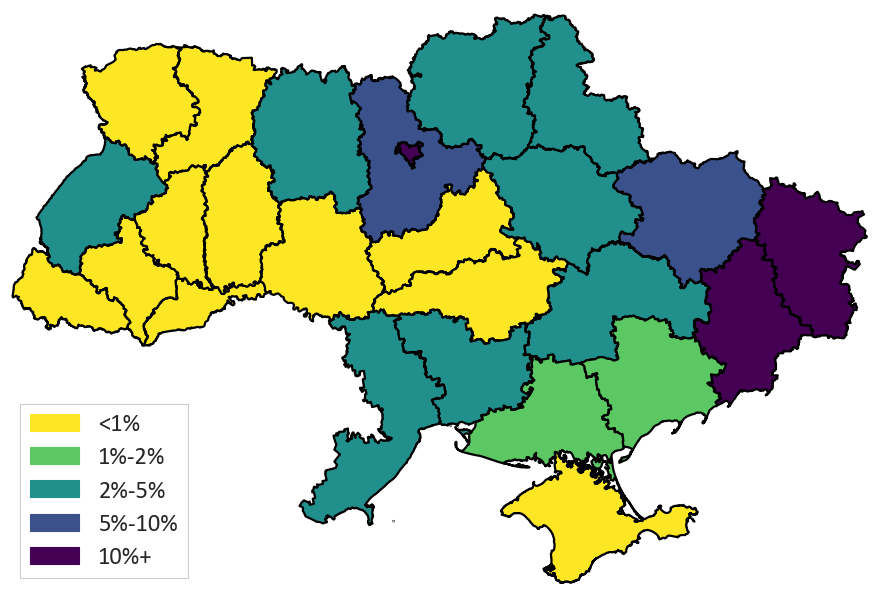

In [56]:
import matplotlib.pyplot as plt

# Set the column to use for the choropleth
all_colors = ['#fde725', '#5cc863', '#21908d', '#3b518b', '#440154']
diff_ranges = [(0, 1), (1, 2), (2, 5), (5, 10),(10,100)]
### 0,17112,43169,74445,118438,198192 previously

def diff_to_color(diff):
    if diff<0:
        return all_colors[0]
    for i, (d_min, d_max) in enumerate(diff_ranges):
        if d_min <= diff < d_max:
            return all_colors[i]
    return all_colors[-1]

# Create a legend for the color scheme
legend_handles = []
legend_labels = []
for i, (diff_range, diff_color) in enumerate(zip(diff_ranges, all_colors)):
    legend_handles.append(plt.Rectangle((0, 0), 2, 2, color=diff_color))
    if i == len(diff_ranges) - 1:
        legend_labels.append(f'{diff_range[0]}%+')
    elif i==0:
        legend_labels.append(f'<{diff_range[1]}%')
    else:
        legend_labels.append(f'{diff_range[0]}%-{diff_range[1]}%')

focus_column = 'displacement_percentage_abm'
ukr_idp_macro_info_df['diff_color'] = ukr_idp_macro_info_df[focus_column].apply(lambda x: diff_to_color(x))
# Create the figure and axis objects
fig,ax = plt.subplots(figsize=(12,8))
#plt.xticks(rotation=30)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 24
rcParams["axes.labelsize"] = 20
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 16
rcParams["ytick.labelsize"] = 16

# Plot the polygons with the choropleth
#polygons_gdf.plot(column=value_column, cmap=cmap, ax=ax, edgecolor='black',scheme='EqualInterval',legend=True,legend_kwds={'fontsize':20,'loc':'lower left'})
ukr_idp_macro_info_df.plot(ax=ax,edgecolor='black',color=ukr_idp_macro_info_df['diff_color'],linewidth=2)

# ukr_idp_macro_info_df['coords'] = ukr_idp_macro_info_df['geometry'].apply(lambda x: x.representative_point().coords[:])
# ukr_idp_macro_info_df['coords'] = [coords[0] for coords in ukr_idp_macro_info_df['coords']]
# for idx, row in ukr_idp_macro_info_df.iterrows():
#     cur_coord = row['coords']
#     if row['Macro-region']=='Kyiv':
#         dx = -2
#         dy = 0.5
#         as_list = list(cur_coord)
#         as_list[0] = as_list[0] + dx
#         as_list[1] = as_list[1] + dy
#         ax.arrow(as_list[0]+0.1,as_list[1],-dx-0.7,-dy+0.2,color='black',head_width = 0.1, head_length = 0.2)
#         cur_coord = tuple(as_list)
#     ax.annotate(s=row['Macro-region'], xy=cur_coord,ha='center',fontsize=20,color='#000000')

# Add a legend
EPS = 0.1
ax.set_xlim(ukr_idp_macro_info_df.total_bounds[0]-EPS, ukr_idp_macro_info_df.total_bounds[2]+EPS)
ax.set_ylim(ukr_idp_macro_info_df.total_bounds[1]-EPS, ukr_idp_macro_info_df.total_bounds[3]+EPS)
ax.legend(handles=legend_handles,labels=legend_labels,loc='lower left',fontsize=22)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True,right=True,top=True,bottom=True)

fig.tight_layout()
#fig.savefig('../Figures/aamas_'+focus_column+'_map.png',dpi=350,bbox_inches='tight')

## compare_everything

In [75]:
x = 7275283.098597599
y = 5523150.002945037
z = 1616600.5681473766
a = 10305552.99151849
b = 7887347.678246012
c = 2202283.6001177765

In [76]:
x_axis = ['Overall','March','April']
Method = ['Observed','ABM','Pandey']
colors = ['#41ab5d','#6a51a3','#ae017e']
values = [[5160175,3321159,1540624],[4917812,3400824,1266664],[8519858,6484278,1881154]]
errmin = [[0,0,0],[values[1][0]-3990658,values[1][1]-2878165,values[1][2]-907943],[values[2][0]-x,values[2][1]-y,values[2][2]-z]]
errmax = [[0,0,0],[6137919-values[1][0],4123093-values[1][1],1711786-values[1][2]],[a-values[2][0],b-values[2][1],c-values[2][2]]]

In [77]:
print(errmin)
print(errmax)

[[0, 0, 0], [927154, 522659, 358721], [1244574.9014024008, 961127.9970549634, 264553.43185262335]]
[[0, 0, 0], [1220107, 722269, 445122], [1785694.99151849, 1403069.678246012, 321129.60011777654]]


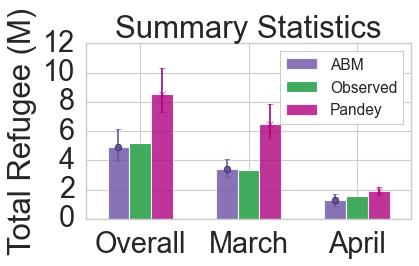

In [105]:
# Numbers of pairs of bars you want
N = len(x_axis)

truth_bar = values[0]
abm_bar = values[1]
pandey_bar = values[2]

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
fig,ax = plt.subplots(figsize=(6,4))

# Width of a bar 
width = 0.2       

# Plotting
ax.bar(ind - width, np.array(abm_bar)/1e6 , width, label='ABM',color=colors[1],alpha=0.8)
ax.errorbar(ind - width, np.array(abm_bar)/1e6, yerr = [np.array(errmin[1])/1e6,np.array(errmax[1])/1e6],fmt='o',color=colors[1])

ax.bar(ind, np.array(truth_bar)/1e6 , width, label='Observed',color=colors[0])

ax.bar(ind + width, np.array(pandey_bar)/1e6 , width, label='Pandey',color=colors[2],alpha=0.8)
ax.errorbar(ind + width, np.array(pandey_bar)/1e6, yerr = [np.array(errmin[2])/1e6,np.array(errmax[2])/1e6],fmt='x',color=colors[2])

ax.set_ylabel('Total Refugee (M)')

ax.set_title('Summary Statistics')

ax.set_xticks(ind)
ax.set_xticklabels(x_axis)
ax.set_yticks
# Finding the best position for legends and putting it
ax.legend(loc='best',fontsize=14,ncol=1)
ax.set_ylim([0,12])
fig.tight_layout()
fig.savefig('../Figures/summary_stat.pdf',dpi=350,bbox_inches='tight')

In [93]:
[errmin[1],errmax[1]]

[[927154, 522659, 358721], [1220107, 722269, 445122]]

In [81]:
np.array(abm_bar)/1e6

array([4.917812, 3.400824, 1.266664])

In [51]:
all_dfs = []
for region in all_ids:
    print(region,end=' ')
    try:
        cur_df = get_results_for_2(5000+101, who='refugee',region_name=[region],prefix='mim_result',partition = 20,scale_1 = 1.2,scale_2 = 1.5)
        cur_df['raion'] = region
        all_dfs.append(cur_df)
        #break
    except:
        print('chesta')
        continue

Bakhchysaraiskyi 1 raions found
Bilohirskyi 1 raions found
Dzhankoiskyi 1 raions found
Yevpatoriiskyi 1 raions found
Kerchynskyi 1 raions found
Krasnohvardiiskyi chesta
Krasnoperekopskyi chesta
Simferopolskyi 1 raions found
Feodosiiskyi 1 raions found
Yaltynskyi chesta
Vinnytskyi 1 raions found
Haisynskyi chesta
Zhmerynskyi 1 raions found
Mohyliv-Podilskyi chesta
Tulchynskyi chesta
Khmilnytskyi 1 raions found
Volodymyrskyi 1 raions found
Kamin-Kashyrskyi 1 raions found
Kovelskyi chesta
Lutskyi 1 raions found
Dniprovskyi 1 raions found
Kamianskyi 1 raions found
Kryvorizkyi 1 raions found
Nikopolskyi 1 raions found
Novomoskovskyi 1 raions found
Pavlohradskyi 1 raions found
Synelnykivskyi 1 raions found
Bakhmutskyi 1 raions found
Volnovaskyi 1 raions found
Horlivskyi 1 raions found
Donetskyi 1 raions found
Kalmiuskyi 1 raions found
Kramatorskyi 1 raions found
Mariupolskyi 1 raions found
Pokrovskyi 1 raions found
Berdychivskyi 1 raions found
Zhytomyrskyi 1 raions found
Korostenskyi 1 raion

In [53]:
pivot_df = pd.concat(all_dfs).pivot(index='raion',columns='time',values='refugee')
each_day_max_raion = pivot_df.idxmax().reset_index()

In [55]:
each_day_max_raion[0].value_counts()

Zaporizkyi      32
Kramatorskyi    12
Alchevskyi       8
Kyiv             8
Kryvorizkyi      8
Chuhuivskyi      7
Kharkivskyi      7
Mykolaivskyi     5
Khersonskyi      5
Donetskyi        2
Name: 0, dtype: int64

In [99]:
def assign_raion_to_dest(hyper_comb, raion, who='refugee',prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 1.2,scale_2 = 1.5):
    all_dfs = []
    f_name = prefix+'_completed_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    f2_name = prefix+'_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    #print(f_name)
    if os.path.isfile(OUTPUT_DIR+f_name):
        true_f_name = f_name
    elif os.path.isfile(OUTPUT_DIR+f2_name):
        true_f_name = f2_name

    cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
    cur_df['time'] = pd.to_datetime(cur_df['time'])
    all_dfs.append(cur_df)
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(ovr_df[who].sum(),end=' ')
    #dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_eu_only_minus_Romania_stock_only_'+str(raion)+'.csv')
    dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_stock_only_eu_only_'+str(raion)+'.csv')
    ovr_df['key'] = 1
    dest_df['key'] = 1
    raion_to_dest = ovr_df[['time','refugee','key']].merge(dest_df[['Country','rij','key']],on='key',how='inner')
    raion_to_dest['flow'] = raion_to_dest['refugee']*raion_to_dest['rij']
    print(raion_to_dest['flow'].sum(),raion)
    raion_to_dest['from'] = raion
    return raion_to_dest

In [100]:
all_dests = []

for raion in all_ids:
    try:
        dest_raion_df = assign_raion_to_dest(5000+101,raion,prefix='mim_result')
        all_dests.append(dest_raion_df)
    except:
        continue

1337.485714285715 1337.485714285715 Bakhchysaraiskyi
26.4 26.4 Bilohirskyi
150.9 150.9 Dzhankoiskyi
165.59999999999997 165.59999999999997 Yevpatoriiskyi
277.5 277.5 Kerchynskyi
3431.0999999999995 3431.1 Simferopolskyi
120.0 120.0 Feodosiiskyi
16826.571428571435 16826.571428571428 Vinnytskyi
1351.5 1351.4999999999998 Zhmerynskyi
328.5 328.49999999999994 Khmilnytskyi
152.4 152.39999999999998 Volodymyrskyi
10.799999999999999 10.799999999999997 Kamin-Kashyrskyi
6888.3 6888.3 Lutskyi
63215.74285714286 63215.74285714286 Dniprovskyi
265.2 265.2 Kamianskyi
375983.9142857143 375983.91428571433 Kryvorizkyi
18583.842857142852 18583.842857142856 Nikopolskyi
477.0 477.0 Novomoskovskyi
3105.814285714286 3105.8142857142866 Pavlohradskyi
1775.0571428571427 1775.057142857143 Synelnykivskyi
68638.28571428574 68638.28571428575 Bakhmutskyi
72995.87142857142 72995.87142857145 Volnovaskyi
263723.3999999996 263723.3999999997 Horlivskyi
505756.41428571334 505756.41428571334 Donetskyi
63817.45714285707 63817.4

In [101]:
all_flow_from_all_raion = pd.concat(all_dests)
all_flow_from_all_raion.groupby('Country')['flow'].sum().reset_index().sort_values(by='flow',ascending=False)

,Country,flow
19,Poland,1.950578e+06
14,Italy,9.055663e+05
10,Germany,7.335411e+05
5,Czech Republic,5.643315e+05
12,Hungary,3.730222e+05
21,Romania,3.225132e+05
24,Spain,2.221435e+05
11,Greece,1.927058e+05
7,Estonia,1.826178e+05
2,Bulgaria,1.458914e+05


In [85]:
raion_df = get_results_for_2(5000+101,region_name=['Kyiv'],prefix='mim_result')
print(raion_df['refugee'].sum())
dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_eu_only_minus_Romania_'+str('Kyiv')+'.csv')
dest_df['rij'].sum()
raion_df['key'] = 1
dest_df['key'] = 1
raion_to_dest = raion_df[['time','refugee','key']].merge(dest_df[['Country','rij','key']],on='key',how='inner')
raion_to_dest['flow'] = raion_to_dest['refugee']*raion_to_dest['rij']
print(raion_to_dest['flow'].sum())

1 raions found
358943.28571428574
357090.9346861782
